In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
import sys
from skimage.metrics import structural_similarity as ssim
from multiprocessing import Pool, Process, Manager
import time
import itertools
import operator
import pickle as pk
from skimage import filters

import autograd

In [2]:
seed = 482

In [3]:
X_train = np.loadtxt('../Data/X_train.csv')
X_test = np.loadtxt('../Data/X_test.csv')
Y_train = np.loadtxt('../Data/Y_train.csv')
Y_test = np.loadtxt('../Data/Y_test.csv')

In [4]:
def sigma(x):
    return 1/(1 + np.exp(-x))

def lae(s, t):
    """
    Compute log add exp 
    Return log(exp(s) + exp(t))
    """
    return np.logaddexp(s, t)

def logp_conditional(y, x, z):
    """
    Compute condition logistic probability
    """
    return -lae(0, -y*(z@x))

def grad_logp_conditional(y, x, z):
    """
    Compute and return the gradient computed at z
    """
    grad = y*x*sigma(-y*(z@x))
    return grad

def norm_prob(x, mu, var):
    prob = (1/np.sqrt(2*np.pi*var))*np.exp(-0.5*((np.linalg.norm(x-mu))**2)/var)
    return prob

def int_estimate(y, x, w, dim=1, var=0.5, msize=2):
    """
    Single Point Estimate of Integral
    """
    ## Sample z_o from Normal distribution
    e_o = np.random.normal(0, 1, dim)
    e_o = np.reshape(e_o, (1, dim))
    z_o = np.sqrt(var)*e_o + w
    
    first_term = np.linalg.norm(z_o)**2
    third_term = np.log(np.sqrt(2*np.pi))
    
    samples = np.random.choice(range(len(y)), msize, replace=False)
    second_term = 0
    for sample_idx in samples:
        second_term += lae(0, -y[sample_idx]*(z_o@x[sample_idx]))
    second_term = (len(y)/msize)*second_term
    
    return -1*q_term*(first_term + second_term + third_term)

def grad_int(y, x, w, dim=1, var=0.5, msize=2):
    """
    Return the gradient of the integral computed at w
    """
    e_o = np.random.normal(0, 1, dim)
    e_o = np.reshape(e_o, (1, dim))
    z_o = np.sqrt(var)*e_o + w
    
    grad = -z_o
    minibatch = np.random.choice(range(len(y)), msize, replace=False)
    batch_grad = np.zeros(np.shape(x[0]))
    for idx in minibatch:
        batch_grad += y[idx]*x[idx]*sigma(-y[idx]*(z_o@x[idx]))

    grad += (len(y)/msize)*batch_grad
    grad = grad
    return grad

## Q4 Compute SGVI

In [6]:
def sgvi(_X_train, _Y_train, step_size=0.005, t_max=10000):
    w = (np.random.random(_X_train.shape[1])-0.5)*6
    w_history = []
    w_history.append(w)
    for t in range(0, t_max):
        g = grad_int(_Y_train, _X_train, w, dim=len(w), msize=100)
        w = w + step_size*g
        w_history.append(w[0])
    return w, w_history

In [7]:
np.random.seed(seed)

wf, wh = sgvi(X_train, Y_train)
print("Optimal Weights:", wf)

Optimal Weights: [[-0.37625044 -0.38763443 -2.86113584  1.49762747 -2.271061  ]]


In [8]:
wh = np.array(wh)
wh.shape

(10001, 5)

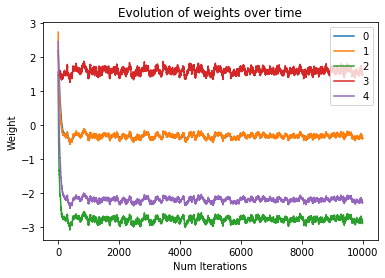

In [9]:
### Plot evolution of w
for d in range(0, 5):
    plt.plot(wh[:, d], label='{}'.format(d))
plt.xlabel('Num Iterations')
plt.ylabel('Weight')
plt.legend()
plt.title("Evolution of weights over time")
plt.savefig("evolq4.png")
plt.show()

## Q5. Prediction with SGVI

In [10]:
#### Run SGVI for various time settings ####
np.random.seed(seed)
times = [10, 100, 1000, 10000]
w_opt_times = {}
for tmax in times:
    _wf, _ = sgvi(X_train, Y_train, step_size=0.005, t_max=tmax)
    w_opt_times[tmax] = _wf

In [11]:
w_opt_times

{10: array([[2.00539264, 2.08499945, 0.23792475, 1.56430716, 1.40221318]]),
 100: array([[-0.0603096 , -0.28593162, -2.2616978 ,  1.44305049, -1.73964793]]),
 1000: array([[-0.32155827, -0.30494616, -2.74418132,  1.61018703, -2.17696443]]),
 10000: array([[-0.30764029, -0.27075793, -2.70773368,  1.68645484, -2.15018007]])}

In [12]:
def pred(samples_z, _x_test):
    probs = []
    for test_id, xt in enumerate(X_test):    
        sums = 0
        for z in samples_z:
            sums = np.logaddexp(logp_conditional(+1, xt, z), sums)
        prob = np.exp(sums)/time
        probs.append(prob)
    return np.array(probs)

In [13]:
def get_error(_preds, _Y_test):
    preds_marked = _preds
    preds_marked[np.where(preds_marked >= 0.5)] = 1
    preds_marked[np.where(preds_marked < 0.5)] = -1
    err = np.sum(np.abs(preds_marked - Y_test))/(2*len(Y_test))
    return err

In [ ]:
np.random.seed(seed)

preds_trials = {}
error_trials = {}
for trial in range(0, 5):
    time = 1000
    samples_e = np.random.normal(0, 1, time*X_train.shape[1])
    samples_e = np.reshape(samples_e, (time, X_train.shape[1]) )

    preds_timed = {}
    error_rates = {}
    for tmax in times:
        _wf = w_opt_times[tmax]
        samples_z  = np.sqrt(0.5)*samples_e + _wf
        _preds_t = pred(samples_z, X_test)
        preds_timed[tmax] = _preds_t

        error_rates[tmax] = get_error(_preds_t, Y_test)
    preds_trials[trial] = preds_timed
    error_trials[trial] = error_rates

In [ ]:
for x in error_trials:
    print(error_trials[x])